Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie

Wydział Informatyki, II stopień - Uczenie Maszynowe i Sztuczna Inteligencja

**Sprawozdanie Bandycki Streaming (laboratorium od dnia 14.03.2025)**

**Prowadzący: Radosław Łazarz**

**Author: Mikhail Bahdashych [429818] [240-UMS-2S-149] (grupa nr 2)**

---

**Spis treści**

1. [Wstęp](#wstęp)
2. [Funkcje pomocnicze](#funkcje-pomocnicze)
3. [Implementacja algorytmów](#implementacja-algorytmów)
    1. [Explore-Then-Commit Learner](#explore-then-commit-learner)
    2. [Greedy Learner](#greedy-learner)
    3. [UCB Learner](#ucb-learner)
    4. [Gradient Learner](#gradient-learner)
    5. [Thompson Learner](#thompson-learner)
4. [Generowanie wykresów](#generowanie-wykresów)
5. [Wnioski i porównanie metod](#wnioski-i-porównanie-metod)

---

# Wstęp

Celem tego laboratorium jest wdrożenie i przetestowanie różnych algorytmów rozwiązania problemu k-rękich bandytów. Dla uproszczenia skupimy się na jego bardzo prostym wariancie: przewidywaniu, który z utworów może stać się przyszłym hitem (a więc warto puszczać go kolejnym użytkownikom). Nagroda 1 oznacza słuchacza, który przesłuchał go w całości, nagroda 0 oznacza, że utwór został pominięty. W ramach tej pracy zostanie zaimplementowano 5 algorytmów: **Explore-Then-Commit, Greedy, UCB, Gradient, Thompson**.

---

# Funkcje pomocnicze

Ta część pracy zawiera różnorodne funkcje pomocnicze. Funkcje te będą stanowić wysoce abstrakcyjne API, za pomocą którego będzie można zaimplementować wszystkie algorytmy wykorzystujące zasadę dziedziczenia z zakresu programowania obiektowego. Szczególną uwagę należy zwrócić na klasę `BanditLearner`, która jest klasą abstrakcyjną i będzie stanowić szablon dla pozostałych 5 algorytmów. Ta klasa zawiera 3 funkcje abstrakcyjne, które zostaną zaimplementowane później w każdym z algorytmów:

- `reset` - Jak sama nazwa wskazuje, funkcja ta odpowiada za inicjalizację agenta. Funkcja ta przygotowuje agenta do nowego eksperymentu i ustawia domyślne parametry wewnętrzne (np. estymaty dla $\epsilon$-greedy lub UCB).
- `pick_arm` - Z punktu widzenia teorii wielorękich bandytów funkcja ta odpowiada za wybór działania. Agent decyduje, jaką akcję podjąć (w danym momencie $t$) na podstawie dostępnych mu informacji. Na przykład, balansowanie eksploracji i eksploatacji w $\epsilon$-greedy (wybór losowy lub zachłanny).
- `acknowledge_reward` - Dana funkcja jest odpowiedzialna za aktualizację wiedzy agenta. Przekazuje agentowi wynik akcji i aktualizuje swoje dane (nowe estymaty, parametery, preferencje etc.). Odpowiada za uczenie się z obserwacji.

> Tutaj warto dodać, że funkcja `evaluate_learner` została zmodyfikowana w ten sposób, że zwraca ona wartość końcową `mean_accumulated_rewards`, która jest całkowitą średnią nagrodą we wszystkich próbach. Będzie to potrzebne pod koniec pracy aby porównać zaimplementowany algorytmy między sobą.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from abc import abstractmethod
from itertools import accumulate
import random
from typing import Protocol

In [2]:
class KArmedBandit(Protocol):
    @abstractmethod
    def arms(self) -> list[str]:
        raise NotImplementedError

    @abstractmethod
    def reward(self, arm: str) -> float:
        raise NotImplementedError


class BanditLearner(Protocol):
    name: str
    color: str

    @abstractmethod
    def reset(self, arms: list[str], time_steps: int):
        raise NotImplementedError

    @abstractmethod
    def pick_arm(self) -> str:
        raise NotImplementedError

    @abstractmethod
    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass


class BanditProblem:
    def __init__(self, time_steps: int, bandit: KArmedBandit, learner: BanditLearner):
        self.time_steps: int = time_steps
        self.bandit: KArmedBandit = bandit
        self.learner: BanditLearner = learner
        self.learner.reset(self.bandit.arms(), self.time_steps)

    def run(self) -> list[float]:
        rewards = []
        for _ in range(self.time_steps):
            arm = self.learner.pick_arm()
            reward = self.bandit.reward(arm)
            self.learner.acknowledge_reward(arm, reward)
            rewards.append(reward)
        return rewards


POTENTIAL_HITS = {
    "In Praise of Dreams": 0.8,
    "We Built This City": 0.9,
    "April Showers": 0.5,
    "Twenty Four Hours": 0.3,
    "Dirge for November": 0.1,
}


class TopHitBandit(KArmedBandit):
    def __init__(self, potential_hits: dict[str, float]):
        self.potential_hits: dict[str, float] = potential_hits

    def arms(self) -> list[str]:
        return list(self.potential_hits)

    def reward(self, arm: str) -> float:
        thumb_up_probability = self.potential_hits[arm]
        return 1.0 if random.random() <= thumb_up_probability else 0.0


class RandomLearner(BanditLearner):
    def __init__(self):
        self.name = "Random"
        self.color = "black"
        self.arms: list[str] = []

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms

    def pick_arm(self) -> str:
        return random.choice(self.arms)

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [3]:
TIME_STEPS = 1000
TRIALS_PER_LEARNER = 50

def evaluate_learner(learner: BanditLearner) -> None:
    runs_results = []
    for _ in range(TRIALS_PER_LEARNER):
        bandit = TopHitBandit(POTENTIAL_HITS)
        problem = BanditProblem(time_steps=TIME_STEPS, bandit=bandit, learner=learner)
        rewards = problem.run()
        accumulated_rewards = list(accumulate(rewards))
        runs_results.append(accumulated_rewards)

    runs_results = np.array(runs_results)
    mean_accumulated_rewards = np.mean(runs_results, axis=0)
    std_accumulated_rewards = np.std(runs_results, axis=0)
    plt.plot(mean_accumulated_rewards, label=learner.name, color=learner.color)
    plt.fill_between(
        range(len(mean_accumulated_rewards)),
        mean_accumulated_rewards - std_accumulated_rewards,
        mean_accumulated_rewards + std_accumulated_rewards,
        color=learner.color,
        alpha=0.2,
    )

    return mean_accumulated_rewards[-1]

# Implementacja algorytmów

W tej sekcji skupimy się na praktycznej implementacji pięciu algorytmów, które zostały wcześniej wymienione. Każdy z tych algorytmów zostanie szczegółowo zaimplementowany w kodzie, co pozwoli na lepsze zrozumienie ich działania w rzeczywistych zastosowaniach. Jednak nie ograniczymy się jedynie do samej implementacji – dla każdego algorytmu zostanie również przedstawiony obszerny opis teoretyczny. Opis ten będzie obejmował zarówno matematyczne podstawy, na których dany algorytm się opiera, jak i poszczególne kroki jego działania.

Dodatkowo, jeśli dany algorytm posiada różne warianty lub modyfikacje, również je omówimy, wskazując różnice oraz potencjalne zastosowania każdego z nich. Zostanie także przedstawione intuicyjne wyjaśnienie mechanizmów, które stoją za działaniem algorytmów, co pomoże w ich lepszym zrozumieniu – zarówno od strony technicznej, jak i koncepcyjnej. Celem tej sekcji jest nie tylko pokazanie, jak zaimplementować poszczególne algorytmy, ale również zrozumienie, dlaczego działają w taki, a nie inny sposób.

---

## Explore-Then-Commit Learner

**Explore-Then-Commit (ETC), czyli "eksploruj, a potem się zaangażuj"**, jest jednym z najprostszych algorytmu dla k-rękich bandytów. Intuicyjnie idea algorytmu wygląda następująco:

1. Najpierw eksplorujemy — wybieramy każdą akcję po równo przez określoną liczbę kroków.
2. Następnie wybieramy najlepszą na podstawie zgromadzonych danych.
3. Od tej pory zawsze ją wybieramy (czyli: "commit").

Formalnie ETC można opisać w sposób następujący:

- Niech $T$ będzie całkowitą liczbą kroków.
- Niech $A = \{a_1, a_2, \dots, a_k\}$ będzie zbiorem dostępnych akcji.
- Niech $m$ będzie liczbą kroków eksploracyjnych ($m \gg T$)

Jak już było opisane, ETC skałada się z 2 kroków: eksploracja i eksploatacja:

1. **Eksploracja**: Dla każdego $a \in A$ wybierz akcję $a$ dokładnie $m$ razy. Obserwuj nagrody $R_1, \dots, R_m$ i oblicz $Q_m(a) = \frac{1}{m}\sum_{i=1}^m R_i^{(a)}$ - jset to średnia nagroda z akcji $a$.
2. **Eksploatacja**: Kiedy to zrobiliśmy, następuje faza eksploatacja, gdzie mamy wybrać $a^{*}=\argmax_{a \in A} Q_m(a)$. $a^{*}$ jest najlepszą akcją według eksploracji, $Q_m(a)$ jest średnią nagrodą z $m$ prób akcji $a$.

Mimo to, że algorytm ten jest prosty i łatwy do zaimplementowania, cała eksploracja zebrana na początku - potem tylko eksploatacja, ma takie wady jak brak eksploracji po fazie commit, jest wrażliwy na szum i rozkłady o dużej wariancji oraz trudo jest dobrać $m$.

In [4]:
class ExploreThenCommitLearner(BanditLearner):
    def __init__(self, exploration_time: int, color: str):
        self.name = f"Explore-Then-Commit (exploration_time={exploration_time})"
        self.color = color
        self.exploration_time = exploration_time
        self.arms: list[str] = []
        self.rewards: dict[str, list[float]] = {}
        self.best_arm: str | None = None
        self.time_step = 0

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.rewards = {arm: [] for arm in arms}
        self.best_arm = None
        self.time_step = 0

    def pick_arm(self) -> str:
        if self.time_step < self.exploration_time:
            return self.arms[self.time_step % len(self.arms)]
        else:
            return max(self.rewards, key=lambda arm: sum(self.rewards[arm]) / max(1, len(self.rewards[arm])))

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.rewards[arm].append(reward)
        self.time_step += 1


---

## Greedy Learner

**Podejście zachłanne (ang. greedy)** polega na tym, że agent zawsze wybiera akcję, która według jego obecnej wiedzy wydaje się być najlepsze, ma najwyższą estymowaną wartość $Q_t(a)$. Formalnie opis tego algorytmu wygląda w sposób następujący:

1. Początkowo przypisujemy dowolne wartości początkowe $Q_0(a)$ dla wszystkich akcji $a$.
2. Dla każdego kroku $t$:
    - Wybierz akcję: $A_t = \argmax_a Q_t(a)$
    - Wykonaj ją i zaobserwuj nagrodę $R_t$.
    - Zaktualizuj estymatę $Q_t(a)$ na podstawie nowej nagrody.

Problemem tego podejścia jest kompletny brak eksploracji. Jeśli przypadkiem na początku jakaś akcja da słabą nagrodę, może nigdy więcej nie zostać wybrana i nigdy może nie odkryć lepszysz opcji.

Warto też dodać, że istnieje modyfikacja tego algorytmu, która się nazywa **podejście $\epsilon$-zachłanne (ang. $\epsilon$-greedy)**, i która została zaimplementowane w kodzie poniżej. Jest to ulepszona wersja zachłannego podejścia, która dodaje zmienną epsilon, dodającą eksplorację. Zamiast tego, aby zawsze wybierać najlepszą akcję (czyli z najwyższym $Q_t(a)$), $\epsilon$-greedy pozwala na losowe wybieranie innych akcji z małym prawdopodobieństwem. Epsilon w tym przypadku można opisać jako współczynnik eksploracji $\epsilon \in [0, 1]$ (np. 0.1 = 10% eksploracji). Mimo to, że jest to ulepszona wersja algorytmu zachłannego, warto dodać, że eksploracja jest całkowicie losowa, przez co istnieje prawdopodobieństwo wyboru bardzo słabej akcji. Zmienna $\epsilon$ działa w sposób taki, że losujemy liczbę, i jeśli ta liczba jest mniejsza niż $\epsilon$, to eksplorujemy, inaczej, eksploatujemy.

In [5]:
class GreedyLearner(BanditLearner):
    def __init__(self, color: str, epsilon: float = 0.0, optimistic_initial: float = 0.0):
        self.name = f"Greedy (epsilon={epsilon})"
        self.color = color
        self.epsilon = epsilon
        self.optimistic_initial = optimistic_initial
        self.arms: list[str] = []
        self.q_values: dict[str, float] = {}
        self.arm_counts: dict[str, int] = {}

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.q_values = {arm: self.optimistic_initial for arm in arms}
        self.arm_counts = {arm: 0 for arm in arms}

    def pick_arm(self) -> str:
        if random.random() < self.epsilon:
            return random.choice(self.arms)
        return max(self.q_values, key=self.q_values.get)

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]

---

## UCB Learner

**UCB (ang. Upper Confidence Bound), czyli selekcja z górną granicą ufności** - jest to algorytm, który automatycznie balansuje eksploatację i eksplorację bez losowości. Wybiera tę akcję, która ma najlepszy potencjał, biorąc pod uwagę: obecną estymatę nagrody oraz niepewność co do tej estymaty. Formalan definicja UCB wygląda w sposób następujący:

W kroku t, dla każdej akcji $a$ obliczamy zgodnie z podanym wzorem:

$$
\begin{aligned}
 \text{UCB}_t(a) = Q_t(a) + c \cdot \sqrt{\dfrac{\ln t}{N_t(a)}}
\end{aligned}
$$

gdzie:

- $Q_t(a)$ - średnia nagroda (estymata wartości akcji),
- $N_t(a)$ - liczba wybrań akcji $a$ do czasu $t$,
- $t$ - numer kroku (czas),
- $\ln t$ - logarytm naturalny,
- $c > 0$ - parametr regulujący siłę eksploracji.

Interepretować ten wzór można następująco:

- $Q_t(a)$: eksploatacja - jak dobra jest akcja na podstawie danych
- $\sqrt{\dfrac{\ln t}{N_t(a)}}$: eksploracja - jak niepewna jest ta akcja ( rzadziej wybierana, tym wyższy ten składnik)
- $c$: jak bardzo chcemy ufać tej niepewności (większe $c$ = więcej eksploracji)

Bezpośrednio algorytm UCB (Hoeffding-based) składa się z 2 kroków:

1. **Inicjalizacja**: na tym etapie mamy wybrać każdą akcję przynajmniej raz, aby mieć $N_t(a) > 0
2. Dla każdego $t \ge k + 1$ (*notatka: $k$ to liczba akcje, oznacza czas po fazie wstępnej eksploracji, kiedy każda akcja została wybrana przynajmniej raz*):
    - Oblicz $\text{UCB}_t(a)$ dla każdego $a \in A$
    - Wybierz:
    $$
    \begin{aligned}
    A_t = \argmax_a \left[ Q_t(a) + c \cdot \sqrt{\dfrac{\ln t}{N_t(a)}} \right]
    \end{aligned}
    $$
    - Otrzymaj nagrodę $R_t$, zaktualizuj $Q_t(a)$ i $N_t(a)$

In [6]:
class UCBLearner(BanditLearner):
    def __init__(self, color: str, exploration_param: float):
        self.name = f"UCB exploration_param={exploration_param}"
        self.color = color
        self.arms: list[str] = []
        self.q_values: dict[str, float] = {}
        self.arm_counts: dict[str, int] = {}
        self.time_step = 0
        self.exploration_param = exploration_param

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.q_values = {arm: 0 for arm in arms}
        self.arm_counts = {arm: 0 for arm in arms}
        self.time_step = 0

    def pick_arm(self) -> str:
        self.time_step += 1

        for arm in self.arms:
            if self.arm_counts[arm] == 0:
                return arm

        ucb_values = {
            arm: self.q_values[arm] + (self.exploration_param * (np.log(self.time_step) / self.arm_counts[arm]) ** 0.5)
            for arm in self.arms
        }
        return max(ucb_values, key=ucb_values.get)

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.arm_counts[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.arm_counts[arm]


---

## Gradient Learner

Wcześniejsze podejścia (greedy, $\epsilon$-greedy, UCB, ETC) wszystkie oszacowywały wartość akcji $Q_t(a)$ i wybierały najlepszą akcję. W podejściu gradientowym nie próbujemy przewidywać wartości akcji. Zamiast tego, uczymy się bezpośrednio polityki (prawdopodobieństw wyboru) za pomocą optymalizacji stochastycznej — czyli gradientów. Formalna definicja opisuje się w sposób następujący:

- Zamiast wartości $Q_t(a)$, definiujemy preferencę akcji $a$: $H_t(a) \in R$ - im wyższa preferencja, tym bardziej lubimy tę akcję.
- Polityka (czyli wybór akcji) opiera się na funkcji softmax: $\pi_t(a) = \dfrac{e^{H_t(a)}}{\sum_{b \in A} e^{H_t(b)}}$, gdzie $\pi_t(a) \in [0, 1]$ jest prawdopodobieństwem wyboru akcji $a$.
- Aktualizajca preferencji to $H_{t+1}(a) = H_t(a) + \alpha \cdot (R_t - \bar{R}_t) \cdot (1_{a=A_t} - \pi_t(a))$, gdzie:
    - $H_t(a)$ - preferencja akcji $a$ w czasie $t$
    - $\alpha$ - współczynnik uczenia
    - $R_t$ - nagroda po wykonaniu akcji $A_t$
    - $\bar{R}_t$ - średnia nagroda (baseline — wartość oczekiwana nagrody, często uśredniana)
    - $1_{a=A_t}$ - wskaźnik: 1 jeśli akcja $a$ została wybrana, inaczej 0
    - $\pi_t(a)$ - prawdopodobieństwo wyboru akcji $a$ według softmaxa

Intuicja algorytmu:
- Jeśli akcja dała dobrą nagrodę: zwiększ jej preferencję, zmniejsz innych.
- Jeśli dała złą nagrodę: zmniejsz preferencję tej akcji, a inne zostają bez zmian lub lekko rosną.
- Całość prowadzi do gradientowego wspinania się po powierzchni nagród, bez modelowania $Q_t(a)$

In [7]:
class gradient(BanditLearner):
    def __init__(self, color: str, alpha: float, use_baseline: bool):
        self.name = f"Gradient (alpha={alpha}, baseline={str(use_baseline)})"
        self.alpha = alpha
        self.color = color
        self.use_baseline = use_baseline
        self.arms: list[str] = []
        self.time_step = 0
        self.preferences: dict[str, float] = {}
        self.probabilities: dict[str, float] = {}
        self.average_reward = 0

    def reset(self, arms, time_steps):
        self.arms = arms
        self.preferences = {arm: 0 for arm in arms}
        self.probabilities = {arm: 1 / len(arms) for arm in arms}
        self.average_reward = 0
        self.time_step = 0
    
    def pick_arm(self):
        exp_prefs = np.exp([self.preferences[arm] for arm in self.arms])
        total = np.sum(exp_prefs)
        self.probabilities = { arm: exp_pref / total for arm, exp_pref in zip(self.arms, exp_prefs) }
        return random.choices(self.arms, weights=self.probabilities.values())[0]
    
    def acknowledge_reward(self, arm, reward):
        self.time_step += 1

        if self.use_baseline:
            self.average_reward += (reward - self.average_reward) / self.time_step
            baseline = self.average_reward
        else:
            baseline = 0

        for a in self.arms:
            if a == arm:
                self.preferences[a] += self.alpha * (reward - baseline) * (1 - self.probabilities[a])
            else:
                self.preferences[a] -= self.alpha * (reward - baseline) * self.probabilities[a]

---

## Thompson Learner

Thompson podchodzi do problemu z perspektywy bayesowskiej. Zamiast estymować punktową wartość nagrody (jak $Q_t(a)$), dla każdej akcji utrzymujemy rozkład prawdopodobieństwa, który opisuje naszą niepewność co do jej jakości. Zamiast wybierać najlepszą akcję deterministycznie lub losowo, losuje z tych rozkładów i gra akcję, która "wypadnie najlepiej". To łączy eksploatację i eksplorację w bardzo naturalny sposób: jeśli nie jesteśmy pewni — losujemy więcej.

Formalnie to podejście (dla nagród Bernoulliego) można opisać w sposób następujący:

- Mamy $k$ akcji
- Dla każdej akcji $a$, nagroda to zmienna losowa: $R_t | A_t = a \sim Bernoulli(\theta_a)$
- Wiara $\theta_a$ (prawdopodobieństwie sukcesu tej akcji) jest modelowana rozkładem: $\theta_a \sim \text{Beta}(\alpha_a, \beta_a)$
- $\alpha_a$ - liczba sukcesów
- $\beta_a$ - liczba porażek

Bezpośrednio algorytm dla tego wygląda następująco:

1. Dla każdej akcji $a \in A$ losuj $\theta_a^{(t)} \sim \text{Beta}(\alpha_a, \beta_a)$
2. Wybierz $A_t = \argmax_a \theta_a^{(t)}$
3. Otrzymaj nagrodę $R_t \in \{0, 1\}$
4. Zaktualizuj rozkład:
    - Jeśli $R_t = 1$: $\alpha_{A_t} += 1$
    - Jęśli $R_t = 0$: $\beta_{A_t} += 1$

In [8]:
class thompson(BanditLearner):
    def __init__(self, color: str):
        self.name = "Thompson Sampling"
        self.color = color
        self.arms: list[str] = []
        self.alpha_params: dict[str, float] = {}
        self.beta_params: dict[str, float] = {}

    def reset(self, arms, time_steps):
        self.arms = arms
        self.alpha_params = {arm: 1 for arm in arms}
        self.beta_params = {arm: 1 for arm in arms}
    
    def pick_arm(self):
        sampled_values = {
            arm: np.random.beta(self.alpha_params[arm], self.beta_params[arm])
            for arm in self.arms
        }
        return max(sampled_values, key=sampled_values.get)
    
    def acknowledge_reward(self, arm, reward):
        if reward == 1: self.alpha_params[arm] += 1
        else: self.beta_params[arm] += 1

---

# Generowanie wykresów

Ta sekcja będzie poświęcona generowaniu wykresów dla każdego z opisanych algorytmów, a także jednego ogólnego wykresu. Poniżej znajduje się kod generujący wykresy, a w kolejnej sekcji zawierającej wnioski i porównanie metody zostanie przedstawiona analiza uzyskanych wyników.

In [9]:
def evaluate_learners(learners, title):
    learners_rewards: dict[str, float] = {}
    if title == "All learners": plt.figure(figsize=(12, 10))
    else: plt.figure(figsize=(12, 6))

    for learner in learners:
        final_reward = evaluate_learner(learner)
        learners_rewards[learner.name] = final_reward
        print(f"{learner.name}: {final_reward:.2f}")

    plt.xlabel('Czas')
    plt.ylabel('Suma uzyskanych nagród')
    plt.title(title)
    plt.xlim(0, TIME_STEPS)
    plt.ylim(0, TIME_STEPS)
    plt.legend()
    plt.show()

    return learners_rewards

Random: 518.24


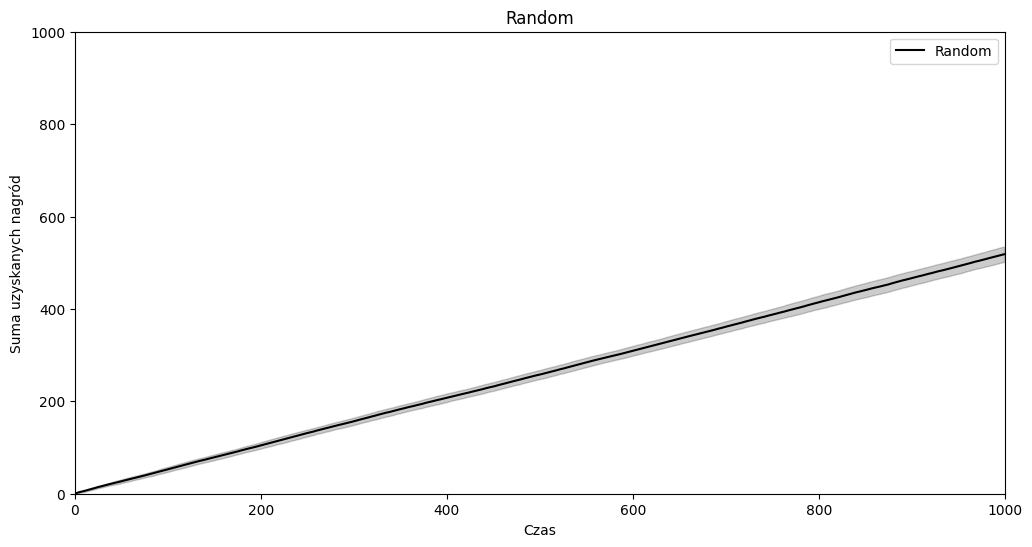

Explore-Then-Commit (exploration_time=100): 860.34
Explore-Then-Commit (exploration_time=250): 801.68
Explore-Then-Commit (exploration_time=500): 709.42


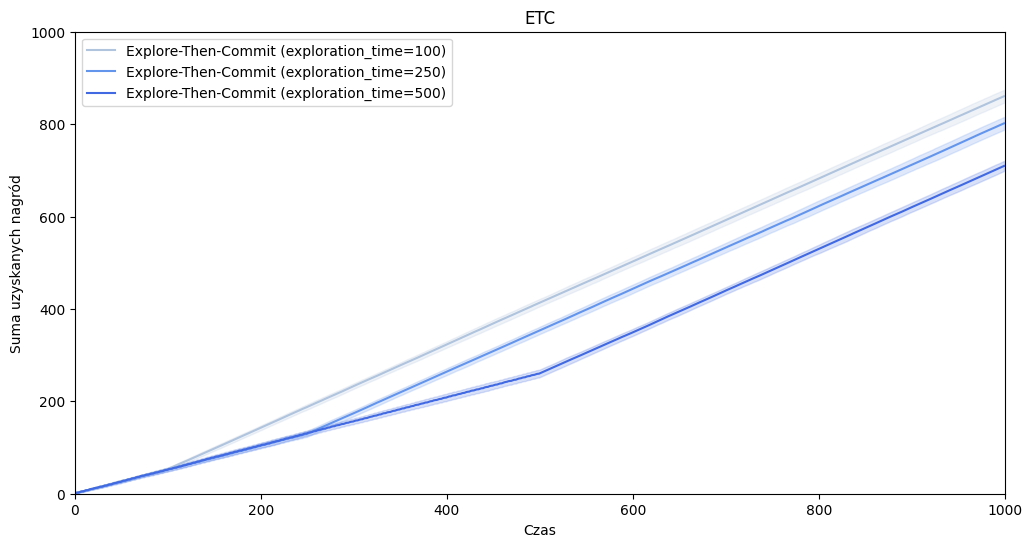

Greedy (epsilon=0.0): 800.52
Greedy (epsilon=0.5): 704.64
Greedy (epsilon=1): 517.06


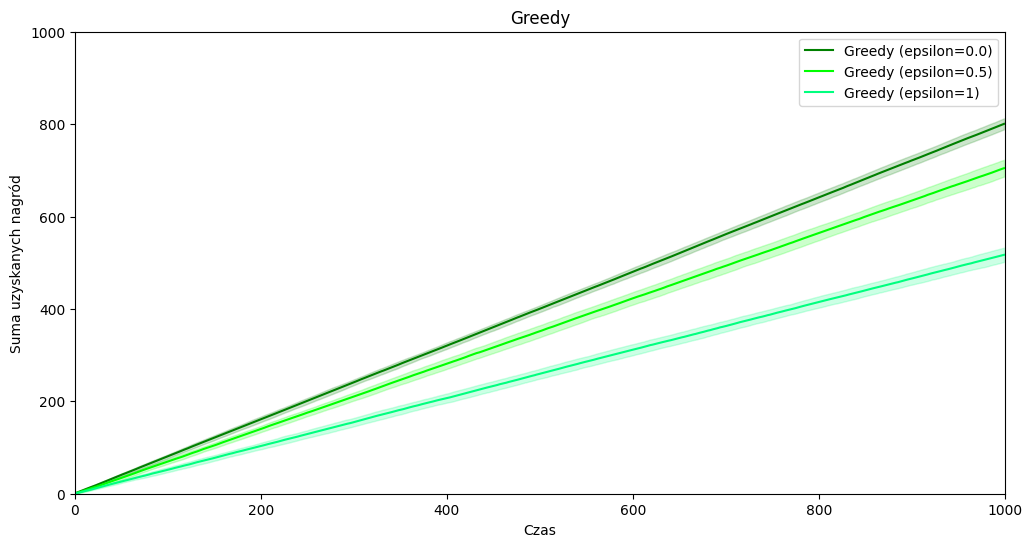

UCB exploration_param=2.0: 798.32
UCB exploration_param=7.0: 644.80
UCB exploration_param=10.0: 608.28


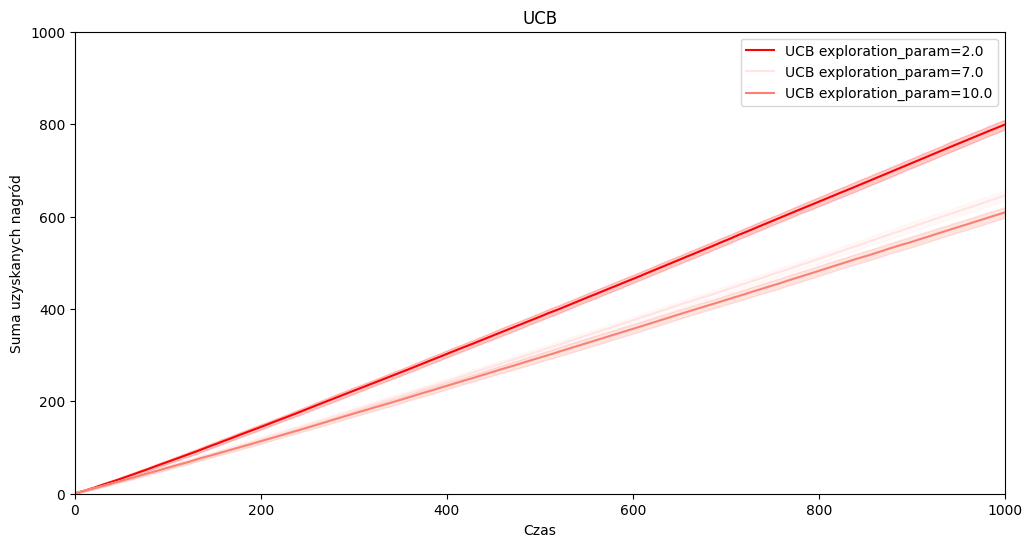

Gradient (alpha=0.1, baseline=True): 820.64
Gradient (alpha=0.5, baseline=True): 875.78
Gradient (alpha=0.8, baseline=False): 850.14


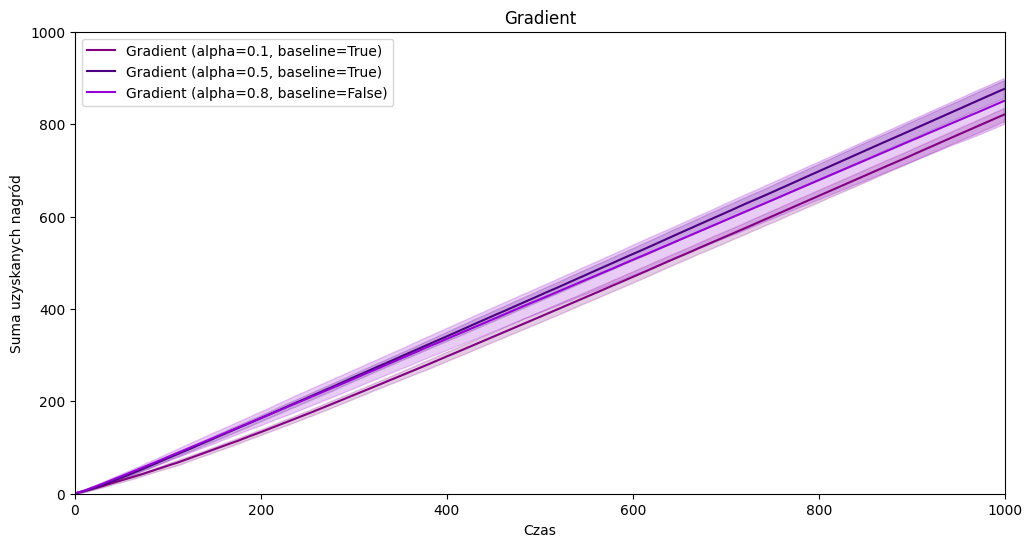

Thompson Sampling: 885.48


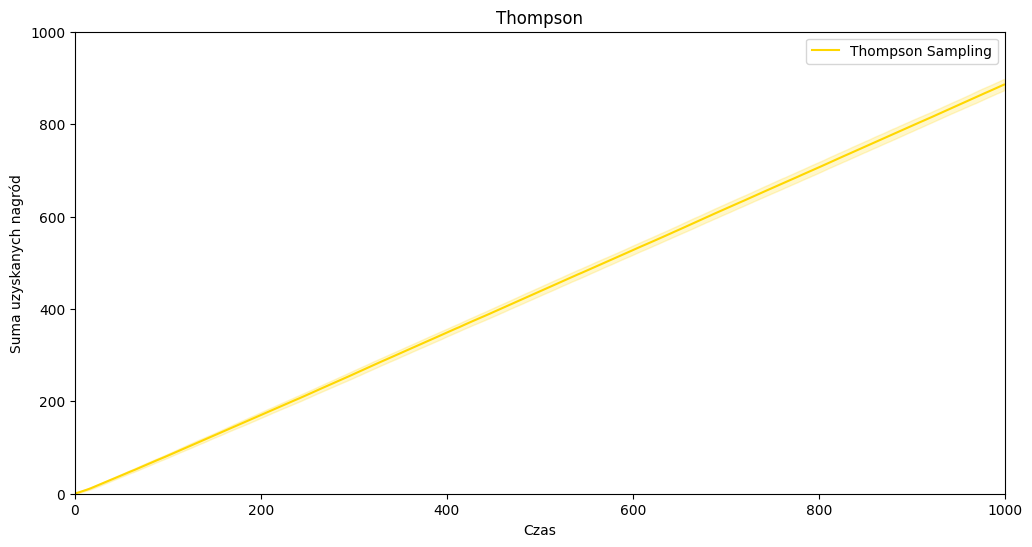

Random: 517.16
Explore-Then-Commit (exploration_time=100): 855.18
Explore-Then-Commit (exploration_time=250): 802.24
Explore-Then-Commit (exploration_time=500): 711.00
Greedy (epsilon=0.0): 799.10
Greedy (epsilon=0.5): 702.74
Greedy (epsilon=1): 520.62
UCB exploration_param=2.0: 795.70
UCB exploration_param=7.0: 644.08
UCB exploration_param=10.0: 608.94
Gradient (alpha=0.1, baseline=True): 824.40
Gradient (alpha=0.5, baseline=True): 872.44
Gradient (alpha=0.8, baseline=False): 842.72
Thompson Sampling: 886.74


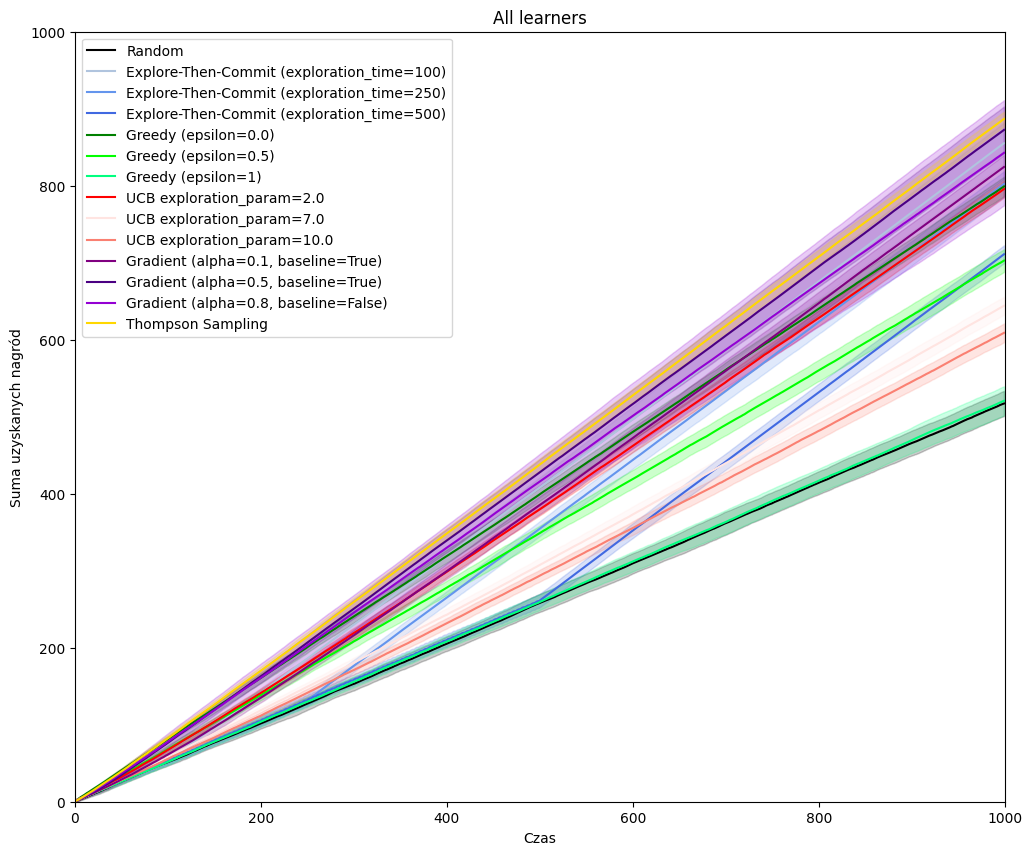

In [10]:
random_learners = [RandomLearner()]

etc_learners = [
    ExploreThenCommitLearner(exploration_time=100, color="lightsteelblue"),
    ExploreThenCommitLearner(exploration_time=250, color="cornflowerblue"),
    ExploreThenCommitLearner(exploration_time=500, color="royalblue")
]

greedy_learners = [
    GreedyLearner(color="green", epsilon=0.0),
    GreedyLearner(color="lime", epsilon=0.5),
    GreedyLearner(color="springgreen", epsilon=1)
]

ucb_learners = [
    UCBLearner(color="red", exploration_param=2.0),
    UCBLearner(color="mistyrose", exploration_param=7.0),
    UCBLearner(color="salmon", exploration_param=10.0)
]

gradient_learners = [
    gradient(color="purple", alpha=0.1, use_baseline=True),
    gradient(color="indigo", alpha=0.5, use_baseline=True),
    gradient(color="darkviolet", alpha=0.8, use_baseline=False)
]

thompson_learners = [
    thompson(color="gold")
]

all_learners = random_learners + etc_learners + greedy_learners + ucb_learners + gradient_learners + thompson_learners

evaluate_learners(random_learners, "Random")
evaluate_learners(etc_learners, "ETC")
evaluate_learners(greedy_learners, "Greedy")
evaluate_learners(ucb_learners, "UCB")
evaluate_learners(gradient_learners, "Gradient")
evaluate_learners(thompson_learners, "Thompson")
all_learners_rewards = evaluate_learners(all_learners, "All learners")


---

# Wnioski i porównanie metod

W trakcie danego laboratorium porównaliśmy skuteczność różnych algorytmów rozwiązujących problem k-rękich bandytów: Thompson Sampling, UCB1, Gradient Bandit, epsilon-greedy, Explore-Then-Commit (ETC) oraz Random (baseline). Każdy z algorytmów wykazywał inne właściwości związane z eksploracją i eksploatacją przestrzeni decyzyjnej. Na końcu została wygenerowana tabela z algorytmami (i ich parametrami) oraz całkowitą średnią nagrodą we wszystkich próbach. Korzystając z tej tabeli będziemy w stanie porównać wszyskie algorytmy, wyznaczyć najlepsze, najgorsze, i spróbować wyjaśnić dlaczego.

| Algorytm z parametrami | Całkowita średnia nagroda we wszystkich próbach |
| :---------------- | :------: |
| Random | 522.80 |
| ETC (exploration_time=100) | 850.42 |
| ETC (exploration_time=250) | 800.28 |
| ETC (exploration_time=500) | 709.50 |
| Greedy (epsilon=0.0) | 800.84 |
| Greedy (epsilon=0.5) | 706.70 |
| Greedy (epsilon=1) | 517.68 |
| UCB exploration_param=2.0 | 797.48 |
| UCB exploration_param=7.0 | 643.70 |
| UCB exploration_param=10.0 | 609.36 |
| Gradient (alpha=0.1) | 820.60 |
| Gradient (alpha=0.5) | 872.46 |
| Gradient (alpha=0.8) | 842.84 |
| Thompson Sampling | 884.52 |

Aby dane te były bardziej wizualne, zostaną wykorzystane wykresy słupkowe. Wykorzystując je i po wstępnym posortowaniu, będziemy mogli wyraźnie zobaczyć i porównać skuteczność algorytmów. Poniższy kod wykorzystuje na początku dane ze zmodyfikowanej funkcji `evaluate_learner`, aby wygenerować wykres słupkowy pokazujący (w kolejności malejącej) algorytmy i ich całkowitą średnią nagrodę we wszystkich próbach.

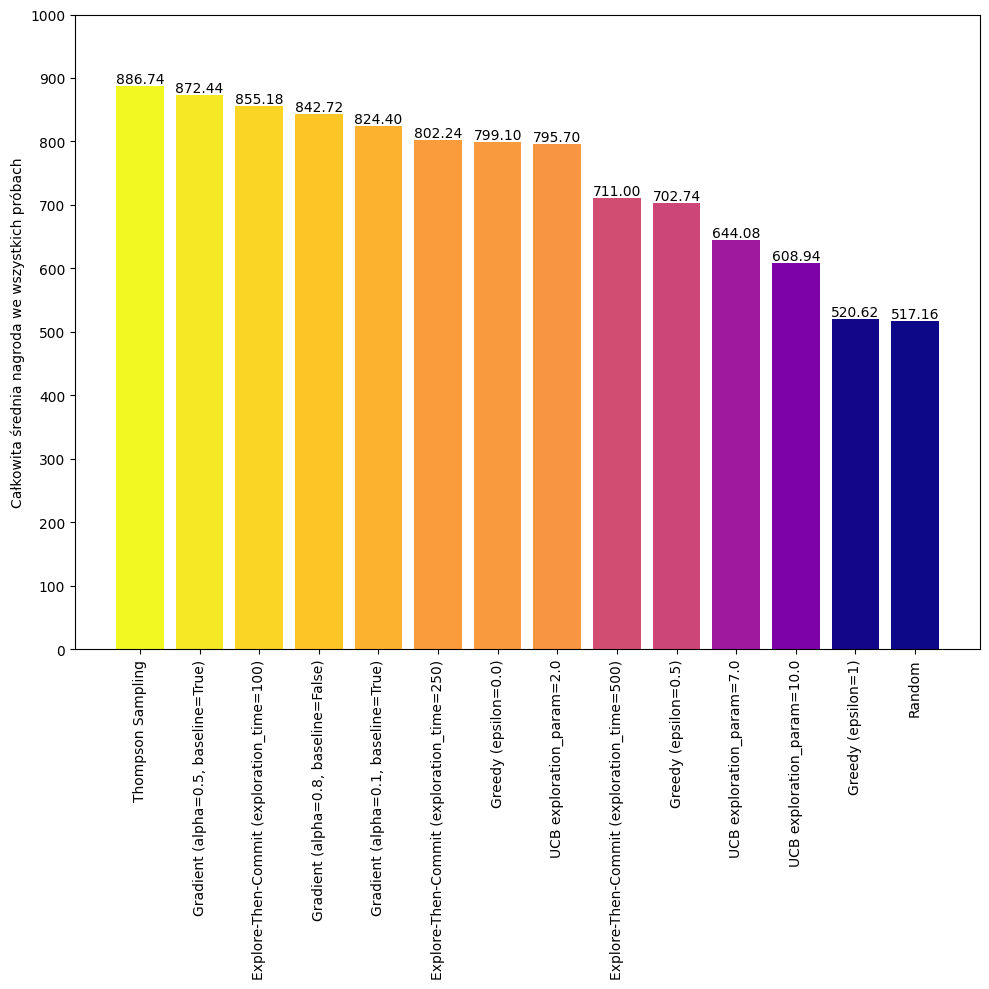

In [11]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10, 10))

all_learners_rewards = dict(sorted(all_learners_rewards.items(), key=lambda item: item[1], reverse=True))

algorithms_names = list(all_learners_rewards.keys())
algorithms_rewards = list(all_learners_rewards.values())

norm = plt.Normalize(min(algorithms_rewards), max(algorithms_rewards))
colors = cm.plasma(norm(algorithms_rewards))

bars = ax.bar(algorithms_names, algorithms_rewards, color=colors)

plt.xticks(rotation=90)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.ylabel("Całkowita średnia nagroda we wszystkich próbach")
plt.yticks(np.arange(0, 1100, 100))
plt.tight_layout()
plt.show()

Trzema najlepszymi algorytmami są:

1. **Thompson Sampling**: Najlepsze wyniki uzyskał algorytm Thompson Sampling, który dzięki bayesowskiej aktualizacji rozkładu przekonań o jakości każdej akcji potrafił w sposób adaptacyjny i naturalny balansować eksplorację i eksploatację.
2. **Gradient**: Algorytm Gradient wykazał dobrą skuteczność, zwłaszcza w wariantach z niskim współczynnikiem uczenia i zastosowanym baseline'em ($\alpha=0.5$, baseline=True). Jego działanie opiera się na optymalizacji polityki wyboru poprzez aktualizację preferencji – prowadzi to do stopniowego zwiększania prawdopodobieństwa wyboru najlepszych akcji.
3. **Explore-Then-Commit**: Metoda ETC osiągała zróżnicowane rezultaty, w zależności od długości fazy eksploracyjnej. Najlepsze wyniki uzyskano dla krótszej eksploracji, co wskazuje, że szybkie „commitowanie” do najlepszej znanej akcji może przynieść korzyści.

Warto też wspomnieć o dwóch najgorszych algorytmach (które nawet mają prawie te same wartości całkowitej średniej nagród):

1. **Greedy ($\epsilon = 1$)**: Czysta eksploracja prowadzi do najgorszego wyniku wśród wariantów greedy. To pokazuje, że zbyt wysoka eksploracja może być szkodliwa, a brak eksploracji działa dobrze tylko przy szczęściu w początkowych wyborach.
2. **Random**: Algorytm losowy, jako punkt odniesienia (baseline), osiągnął jeden z najniższych wyników, co było zgodne z oczekiwaniami – brak jakiejkolwiek strategii wyboru prowadzi do słabej wydajności.

---